The basic goal of this script is to construct the necessarily reconstruction to measure event pileup in the TMS straight from edep-sim output to avoid any of the choices made by dune-tms. 

In [1]:
#imports
import uproot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import awkward as ak
import numpy as np
import math
import ROOT as root
from array import array
from numba import jit
from collections import defaultdict

Welcome to JupyROOT 6.26/16


In [3]:
#Get the edep-file
edep_file = root.TFile("/sdf/home/t/tanaka/MicroProdN4p1_NDComplex_FHC.spill.full.0002459.EDEPSIM_SPILLS.root") 
geom = edep_file.Get("EDepSimGeometry") #relevant for the bar finding
#events tree
edep_evts = edep_file.Get("EDepSimEvents") 
total_events = edep_evts.GetEntries()
print(total_events)

5978


Warning in <TGeoManager::Init>: Deleting previous geometry: EDepSimGeometry/Simulated Detector Geometry
Info in <TGeoManager::CloseGeometry>: Geometry loaded from file...
Info in <TGeoManager::SetTopVolume>: Top volume is volWorld_PV. Master volume is volWorld_PV
Info in <TGeoManager::Voxelize>: Voxelizing...
Info in <TGeoManager::CountLevels>: max level = 23, max placements = 1535
Info in <TGeoManager::CloseGeometry>: 1643903 nodes/ 8916 volume UID's in Simulated Detector Geometry
Info in <TGeoManager::CloseGeometry>: ----------------modeler ready----------------


In [3]:
#This is how we could fill up a lookup table with neutrino vertex info for each event. 
#detsim tree to get vertices. Think to keep consistent with the hits I'll make it a list of dictionaries
edep_detsim = edep_file.Get("DetSimPassThru") #detsimpassthru directory
gRooTrackerTree = edep_detsim.gRooTracker #get the proper tree
edep_true_neutrino_vtx = [] #np.zeros((total_events, 5))
vtxs = array('d', [0.0]*4)  # 'd' for double
gRooTrackerTree.SetBranchAddress("EvtVtx", vtxs)
for i in range(gRooTrackerTree.GetEntries()):
    gRooTrackerTree.GetEntry(i)
    #don't forget to scale positions - will also need to scale energy eventually
    vtx_data = {
        "neutrino_num": i,
        "x": vtxs[0]*1000,
        "y": vtxs[1]*1000,
        "z": vtxs[2]*1000,
        "t": vtxs[3],
    }
    edep_true_neutrino_vtx.append(vtx_data)
    
#print(edep_true_neutrino_vtx)
#np.shape(edep_true_neutrino_vtx)

In [4]:
#Can add another line here to just save stuff to an array for later saving
neutrino_number = []
neutrino_x = []
neutrino_y = []
neutrino_z = []
neutrino_t = []
for entry in edep_true_neutrino_vtx:
    neutrino_number.append(entry['neutrino_num'])
    neutrino_x.append(entry['x'])
    neutrino_y.append(entry['y'])
    neutrino_z.append(entry['z'])
    neutrino_t.append(entry['t'])

neutrino_vertex_array = np.column_stack((neutrino_number,neutrino_x,neutrino_y,neutrino_z,neutrino_t))


    

In [5]:
#Now lets take a look at the hit segments:
edep_evt = root.TG4Event()
edep_evts.SetBranchAddress("Event",root.AddressOf(edep_evt))
edep_evts.GetEntries() #this is just to check the number of entries again

5978

In [65]:
#n_number = 0 
#edep_evts.GetEntry(n_number) #the 0th event, associated with the 0th neutrino vertex, just as a proof of concept!
#hit_segments = edep_evt.SegmentDetectors['volTMS'] #the hit segment associated with the 0th event, in the TMS
#when this eventually is looping over all of our hit-segments we will want to make sure that we are first checking that the hit_segment.size() is non-zero
#edep_evt.EventId

A basic function to identify the orientation, bar, and plane of a given hit location - uses hit location and geometry Note - there is a TMS .scale attribute that gets applied -> geometry can be in either cm or mm, so want to make sure that we are in the correct one... a little silly but we can add something to check at the top. Ok I'm actually fairly sure the scale is 1mm -- we can double check later if needed

In [66]:
def ModuleFinder(x,y,z,geom):
    module_names = {'modulelayervol1' : 'U' ,'modulelayervol2' : 'V' ,'modulelayervol3': 'X' ,'modulelayervol4' : 'Y'}
    node = geom.FindNode(x, y, z)
    orientation = 'null'
    bar_number = 'null'
    layer_number = 'null'
    widths = [0,0,0]
    bar_positions = array('d', [x, y, z]) #hold bar positions as just hit x,y,z for now bar_positions = array('d', [0.0, 0.0, 0.0])
    while node:
        #print(node.GetName())
        #print(node.GetNumber())
        if 'scinBox' in node.GetName(): #this is like a rlly stupid line but let's just hope it works
            bar_number = node.GetNumber()
            box = geom.GetCurrentVolume().GetShape()
            local = array('d', [0.0, 0.0, 0.0])  # 'd' = C double
            geom.GetCurrentMatrix().LocalToMaster(local, bar_positions) #assigning the center of the bar to the hit -- basically just PyROOTED dune-tms code.
            widths[0] = 2 * box.GetDX()
            widths[1] = 2 * box.GetDY()
            widths[2] = 2 * box.GetDZ()
        if "modulelayervol" in node.GetName():
            layer_number = node.GetNumber()
            for module_name in module_names.keys():
                if module_name in node.GetName():
                    orientation = module_names[module_name]
                    #print(module_name)
        if 'volDetEnclosure' in node.GetName():
            break
        geom.CdUp()
        node = geom.GetCurrentNode()

    if orientation == 'X':
        bar_positions[0] = -99999000  # remove X information -- irrelevant given geometry
        xw, yw = yw, xw               # flip widths --apparently root handles incorrectly for x-bars
    elif orientation in ['U', 'V', 'Y']:
        bar_positions[1] = -99999000  # remove Y information -- irrelevant given geometry
    else:
        bar_positions = [-99999000, -99999000, -99999000]

    return (widths, orientation, bar_number, layer_number, bar_positions)

In [67]:
#Test of ModuleFinder
true_x_hit, true_y_hit, true_z_hit = -2825.8306180555574, -447.8311449193576, 17594.793326825627
widths, bar_orientation, bar_no, layer_no, bar_positions = ModuleFinder(true_x_hit, true_y_hit, true_z_hit, geom) 
print(bar_orientation)
print(bar_no)
print(layer_no)
print(widths[0])
print(bar_positions)

U
15
45
35.42
array('d', [-2865.8973940285596, -99999000.0, 17593.0])


This is the most basic class - consists simply of a positionally averaged TMS hit, drawn straight from the TMS hit segment. 

In [68]:
class TMS_hit_simple:
    def __init__(self, tms_hit_seg, neutrino_number, hit_number):
        self.tms_hit_seg = tms_hit_seg
        self.neutrino_number = neutrino_number #associated with what neutrino vertex
        self.hit_number = hit_number #which TMS hit in the event
        self.x_diff = 0.
        self.y_diff = 0.
        self.z_diff = 0.
        self.Dx = 0.
        
    #Defining attributes based on the tms_hit_seg, avg position in each dimension plus time and energy deposition
    def GetNeutrinoNumber(self):
        return(self.neutrino_number)
        
    def GetHitNumber(self):
        return(self.hit_number)
        
    def GetHitX(self):
        x_pos = (self.tms_hit_seg.GetStart()[0] + self.tms_hit_seg.GetStop()[0]) / 2 
        return(x_pos)
        
    def GetHitY(self):
        y_pos = (self.tms_hit_seg.GetStart()[1] + self.tms_hit_seg.GetStop()[1]) / 2
        return(y_pos)
        
    def GetHitZ(self):
        z_pos = (self.tms_hit_seg.GetStart()[2] + self.tms_hit_seg.GetStop()[2]) / 2
        return(z_pos)
        
    def GetHitT(self):
        time = (self.tms_hit_seg.GetStart()[3] + self.tms_hit_seg.GetStop()[3]) / 2
        return(time)
        
    def GetDx(self):
        self.x_diff = (self.tms_hit_seg.GetStart()[0] - self.tms_hit_seg.GetStop()[0])
        self.y_diff = (self.tms_hit_seg.GetStart()[1] - self.tms_hit_seg.GetStop()[1])
        self.z_diff = (self.tms_hit_seg.GetStart()[2] - self.tms_hit_seg.GetStop()[2])
        self.Dx = ((self.x_diff)**2 + (self.y_diff)**2 + (self.z_diff)**2)**(1/2)
        return(self.Dx)
        
    def GetPrimaryDeposit(self):
        PrimaryDeposit = self.tms_hit_seg.GetEnergyDeposit()
        return(PrimaryDeposit)
    
    

Several useful functions in simulating hit-wise detector effects - some impact PE others impact the timing. 

In [69]:
# ------ Functions pertaining to the Optical Simulation ------- #

#Odds are I eventually package this into a different python file along with the class definitions. 
rand_seed = 42
def GetTrueDistanceFromReadout(TMS_hit_reco):
    TMS_Start_Bars_Only = [-3350, -2950]
    TMS_End_Bars_Only = [3350, 240]
    #XBars are weird
    if (TMS_hit_reco.GetBarOrientation == 'X'):
        if (TMS_hit_reco.GetTrueHitPosition()[0] < 0):
            return(TMS_hit_reco.GetTrueHitPosition()[0] - TMS_Start_Bars_Only[0])
        else:
            return(TMS_End_Bars_Only[0] - TMS_hit_reco.GetTrueHitPosition()[0])
    #All other bar orientations (U,V,Y)
    else:
        return(TMS_End_Bars_Only[1] - TMS_hit_reco.GetTrueHitPosition()[1])

def GetTrueLongDistanceFromReadout(TMS_hit_reco):
    TMS_Start_Bars_Only = [-3350, -2950]
    TMS_End_Bars_Only = [3350, 240]
    additional_length = 0.
    #XBars
    if (TMS_hit_reco.GetBarOrientation == 'X'):
        additional_length = 2 * TMS_End_Bars_Only[0] #2 * XBar Length
    #All other bar orientations (U,V,Y)
    else:
        additional_length = 2 * (TMS_End_Bars_Only[1] - TMS_Start_Bars_Only[1]) #2* YBar Length
    return( additional_length - GetTrueDistanceFromReadout(TMS_hit_reco) )

def GetTrueDistanceFromMiddle(TMS_hit_reco):
    TMS_Start_Bars_Only = [-3350, -2950]
    TMS_End_Bars_Only = [3350, 240]
    additional_length = 0.
    #XBars
    if (TMS_hit_reco.GetBarOrientation == 'X'):
        additional_length = 0.5 * TMS_End_Bars_Only[0]
    #All other bar orientations (U,V,Y)
    else:
        additional_length = 0.5 * (TMS_End_Bars_Only[1] - TMS_Start_Bars_Only[1])
    return( GetTrueDistanceFromReadout(TMS_hit_reco) - additional_length )
        
def GetTrueLongDistanceFromMiddle(TMS_hit_reco):
    TMS_Start_Bars_Only = [-3350, -2950]
    TMS_End_Bars_Only = [3350, 240]
    additional_length = 0.
    #XBars
    if (TMS_hit_reco.GetBarOrientation == 'X'):
        additional_length = 0.5 * TMS_End_Bars_Only[0]
    #All other bar orientations (U,V,Y)
    else:
        additional_length = 0.5 * (TMS_End_Bars_Only[1] - TMS_Start_Bars_Only[1])
    return( GetTrueLongDistanceFromReadout(TMS_hit_reco) - additional_length )

#Models the effect of birk suppression on the total PE
def BirkSuppress(de, dx, pe): #de is energy
    birks_constant = 0.0905
    dedx = 0
    if (dx > 1e-8):
        dedx = de / dx
    else: 
        dedx = de / 1.0;
    return(pe * (1.0 / (1.0 + birks_constant * dedx)))

#Selects PEs as traveling in the long or short directions - then models the effect on the PE for traveling the long or short distance. Returns corrected PE
def FiberLengthSim(pe, TMS_hit_reco):
    #Constant used
    wsf_decay_constant = 1 / 4.160
    wsf_length_multiplier = 1.8 
    wsf_fiber_reflection_eff = 0.95
    readout_coupling_eff = 1.0
    
    #Select the PEs traveling in either direction. 
    rng = np.random.default_rng(seed = rand_seed)
    pe_short = pe #what is number of pe's that travel the short path
    pe_long = 0 #what is the number of pe's that travel the long path
    pe = rng.poisson(pe)
    pe_short = rng.binomial(n = pe, p = 0.5)
    pe_long = pe - pe_short
    
    #these next calculations are done in meters to make it a bit easier, hence the conversions, models attenuation. 
    distance_from_end = GetTrueDistanceFromReadout(TMS_hit_reco) * 1e-3
    long_way_distance_from_end = GetTrueLongDistanceFromReadout(TMS_hit_reco) * 1e-3
    distance_from_end *= wsf_length_multiplier
    long_way_distance_from_end *= wsf_length_multiplier

    #attentuation
    pe_short = pe_short * math.exp(-wsf_decay_constant * distance_from_end)
    pe_long = pe_long * math.exp(-wsf_decay_constant * long_way_distance_from_end) * wsf_fiber_reflection_eff
    
    #could couple to additional optical fiber but we are going to go ahead and neglect that - default setting is to neglect. 
    pe_short *= readout_coupling_eff
    pe_long *= readout_coupling_eff

    #return the PE post attenuation, as well as some other useful bits of information for other functions 
    return( ( (pe_short + pe_long), pe_short, pe_long ) )

    
# ------ Functions pertaining to the Hit-Wise Timing Simulation ------- #

def HitTimingSim(TMS_hit_reco):
    rng = np.random.default_rng(seed=rand_seed)
    #Constant
    SPEED_OF_LIGHT = 0.2998  # m/ns
    FIBER_N = 1.5
    SPEED_OF_LIGHT_IN_FIBER = SPEED_OF_LIGHT / FIBER_N
    scintillator_decay_time = 3.0  # ns
    wsf_decay_time = 20.0  # ns
    wsf_length_multiplier = 1.8 

    # Gaussian noise: mean = 0.0, std dev = 1.0 ns
    noise_distribution = lambda: rng.normal(loc=0.0, scale=1.0)

    # Coin flip: returns 0 or 1
    coin_flip = lambda: rng.integers(low=0, high=2)  # high=2 is exclusive

    # Exponential decay distributions (rate = 1 / decay time)
    exp_scint = lambda: rng.exponential(scale=scintillator_decay_time)  # mean = 3 ns
    exp_wsf = lambda: rng.exponential(scale=wsf_decay_time)             # mean = 20 ns

    #begin determining timing effect t here is the added time. 
    t = 0.
    t += noise_distribution()
    distance_from_middle = (GetTrueDistanceFromMiddle(TMS_hit_reco) * 1e-3) * wsf_length_multiplier
    long_way_distance = (GetTrueLongDistanceFromMiddle(TMS_hit_reco) * 1e-3) * wsf_length_multiplier
    time_correction = distance_from_middle / SPEED_OF_LIGHT_IN_FIBER;
    time_correction_long_way = long_way_distance / SPEED_OF_LIGHT_IN_FIBER;

    pe_short_path = TMS_hit_reco.GetRecoPE()[1]
    pe_long_path = TMS_hit_reco.GetRecoPE()[2]
    minimum_time_offset = 1e100

    MAX_PE_THROWS = 300

    #serves to cap the number of throws we do (little difference past 300)
    if (pe_short_path > MAX_PE_THROWS):
        pe_short_path = MAX_PE_THROWS
    while (pe_short_path > 0):
        time_offset = time_correction
        time_offset += exp_scint()
        time_offset += exp_wsf()
        minimum_time_offset = min(time_offset, minimum_time_offset) #take whatever is less
        pe_short_path -= 1

    #serves to cap the number of throws that we do (little difference past 300)
    if (pe_long_path > MAX_PE_THROWS):
        pe_long_path = MAX_PE_THROWS
    
    while (pe_long_path > 0):
        time_offset = time_correction_long_way
        time_offset += exp_scint()
        time_offset += exp_wsf()
        minimum_time_offset = min(time_offset, minimum_time_offset) #take whatever is less
        pe_long_path -= 1

    t += minimum_time_offset
    return (t + TMS_hit_reco.GetTrueHitT()) #return the true hit time + the determined travel effects.


Useful functions to simulate multi-hit effects -- This is where we could simulate deadtime:

In [70]:
# ------ Functions pertaining to multi-event effects ------- #

#merges hits that occur in same readout window and on same scintillator strip. Takes a list of reco hit dictionaries
#this function is not durable to xbars. (ie, where y coordinate is the specified one) - correct this
#I know as it stands this will flag each coincident hit twice, just dealing with it for now. Also... way too slow. Much room for improvement 

def ToArray(reco_hits):
    reco_hit_xs = []
    reco_hit_zs = []
    reco_hit_ys = []
    reco_hit_ts = []
    reco_hit_nn = []
    reco_hit_pe = []
    reco_hit_hn = []
    for hit in reco_hits:
        if not hit['pedestal_subtracted?']:
            reco_hit_xs.append(hit['hit_reco_position'][0])
            reco_hit_ys.append(hit['hit_reco_position'][1])
            reco_hit_zs.append(hit['hit_reco_position'][2])
            reco_hit_ts.append(hit['hit_reco_T'])
            reco_hit_nn.append(hit['neutrino_num'])
            reco_hit_hn.append(hit['hit_num'])
            reco_hit_pe.append(hit['hit_reco_PE'][0])


    array = np.column_stack((reco_hit_nn, reco_hit_hn, reco_hit_xs, reco_hit_ys, reco_hit_zs, reco_hit_ts, reco_hit_pe))
    return(array)
    

                
    
   
    

This class allows us to apply reconstruction effects! - It inherits from a tms_hit_simple object, so make sure one of those exists! Also needs a geometry
I'm like 100% sure there is a way to do direct inheritance - ie to allow us to just store the entire TMS_simple_hit class in TMS_hit_reco!

In [71]:
class TMS_hit_reco:
    def __init__(self, tms_hit_simple, geo):
        self.tms_hit_simple = tms_hit_simple
        self.geo = geo
        #Run the ModuleFinder() function immediately
        self.widths, self.bar_orientation, self.bar_no, self.layer_no, self.bar_positions = ModuleFinder(self.tms_hit_simple.GetHitX(), self.tms_hit_simple.GetHitY(), self.tms_hit_simple.GetHitZ() , self.geo)
        
    #Attributes which inherit directly from tms_hit_simple!!
    
    #We will want to include neutrino number here - directly inherited from the other class. Will probably often be just dealing with these hits. 
    def GetNeutrinoNumber(self):
        return(self.tms_hit_simple.GetNeutrinoNumber())

    def GetHitNumber(self):
        return(self.tms_hit_simple.GetHitNumber())
        
    def GetTrueHitPosition(self):
        return ( (self.tms_hit_simple.GetHitX(), self.tms_hit_simple.GetHitY(), self.tms_hit_simple.GetHitZ()) )
    
    def GetTrueHitT(self):
        return(self.tms_hit_simple.GetHitT())

    def GetDx(self):
        return(self.tms_hit_simple.GetDx())
        
    #One final inheritance - the true hit primary deposition. 
    
    def GetTrueHitPrimDeposition(self):
        return(self.tms_hit_simple.GetPrimaryDeposit())

    def GetRecoPE(self):
        #note, the 0th index here is what we generally want, the other two are for detector sim calls. 
        initial_PE = self.tms_hit_simple.GetPrimaryDeposit() * 50.0  #E to PE with conversion 
        suppressed_PE = BirkSuppress( self.tms_hit_simple.GetPrimaryDeposit(), self.GetDx(), initial_PE ) #apply BirkSuppression
        reco_PE, short_pe, long_pe = FiberLengthSim(suppressed_PE, self)
        return(reco_PE, short_pe, long_pe)
        
    def GetPedestalSubtractedStatus(self): #true if hit is pedestal subtracted
        if (self.GetRecoPE()[0] < 3.0):
            return(True)

        else:
            return(False)
        
    #Attributes which are dependent on the bar segmentation
    
    def GetBarHitPos(self):
        return(self.bar_positions)
        
    def GetBarNo(self):
        return(self.bar_no)
        
    def GetBarLayer(self):
        return(self.layer_no)  

    def GetBarOrientation(self):
        return(self.bar_orientation)
        
    #this will be updated with timing info!
    def GetRecoHitT(self):
        return(HitTimingSim(self))
        

In [72]:
#Test Bench - pull a random hit.
edep_evts.GetEntry(6)
hit_segments = edep_evt.SegmentDetectors['volTMS']
test_simple = TMS_hit_simple(hit_segments[0], 6, 0)
test_reco = TMS_hit_reco(test_simple, geom)
test_reco.GetNeutrinoNumber()
print(test_reco.GetBarHitPos())
print(test_reco.GetTrueHitT())
print(test_reco.GetDx())
print(test_reco.GetPedestalSubtractedStatus())
print(test_reco.GetTrueHitPrimDeposition()*50) 
print(test_reco.GetRecoPE())
print(test_reco.GetRecoHitT())
print(test_reco.GetTrueHitT())

array('d', [-2299.9540640924474, -99999000.0, 11368.0])
199.86749839697353
10.2432750216337
False
86.1001193523407
(23.080016551194923, 13.943274486683375, 9.136742064511548)
210.03587708090737
199.86749839697353


TMS_Event_Processor takes as an argument a edep-sim events directory. The purpose of this function is to assemble an output tuple with the truth and reconstructed information. Recall: truth info has had no effects applied other than averaging over the hit segment (only way to actually collect info on a hit segment). While some reconstruction effects (ped subtraction, barification) are applied in the generator for those classes, some reco effects are event level (hit merging) and need to be handled in this script. 

In [73]:
def TMS_Event_Processor(edep_evts, n_events = 10, verbose = False):
    true_hits_info = []
    reco_hits_info = []
    for n in range(n_events):
        edep_evts.GetEntry(n) #the nth event, associated with the nth neutrino vertex
        hit_segments = edep_evt.SegmentDetectors['volTMS'] #fetching the hit_segment vector for this event
        if hit_segments.size() > 0: #checking the size of the hit segment, make sure we have TMS events 
            if verbose:
                print(f"{hit_segments.size()} TMS hits found in neutrino interaction number {n}, creating truth and rec hit objects") 
            for i in range(hit_segments.size()):
                hit_true = TMS_hit_simple(hit_segments[i], n, i) #takes the hit segment, the neutrino number, and the hit number
                hit_reco = TMS_hit_reco(hit_true, geom)
                #Fill the truth 
                hit_truth_data = {
                    "neutrino_num": hit_true.GetNeutrinoNumber(),
                    "hit_num": hit_true.GetHitNumber(),
                    "x": hit_true.GetHitX(),
                    "y": hit_true.GetHitY(),
                    "z": hit_true.GetHitZ(),
                    "t": hit_true.GetHitT(),
                    "primary_energy": hit_true.GetPrimaryDeposit(),
                    }
                hit_reco_data = {
                    "neutrino_num": hit_reco.GetNeutrinoNumber(),
                    "hit_num": hit_reco.GetHitNumber(),
                    "hit_reco_position": hit_reco.GetBarHitPos(),
                    "hit_reco_PE": hit_reco.GetRecoPE(),
                    "pedestal_subtracted?" : hit_reco.GetPedestalSubtractedStatus(),
                    "hit_true_T" : hit_reco.GetTrueHitT(),
                    "hit_reco_T" : hit_reco.GetRecoHitT(),
                    }
                true_hits_info.append(hit_truth_data)
                reco_hits_info.append(hit_reco_data)
        else:
            if verbose:
                print(f"NO TMS hits found in neutrino interaction number {n}")
        
    return( (true_hits_info , reco_hits_info ) )

In [48]:
%%time
events_info = TMS_Event_Processor( edep_evts, n_events = 5978)
print("done!")
reco_hits_info = events_info[1]
truth_hits_info = events_info[0]

done!
CPU times: user 7min 34s, sys: 4.89 s, total: 7min 39s
Wall time: 7min 41s


We can plot a hit z vs x and PE to demonstrate the effect of some of the reconstruction. 

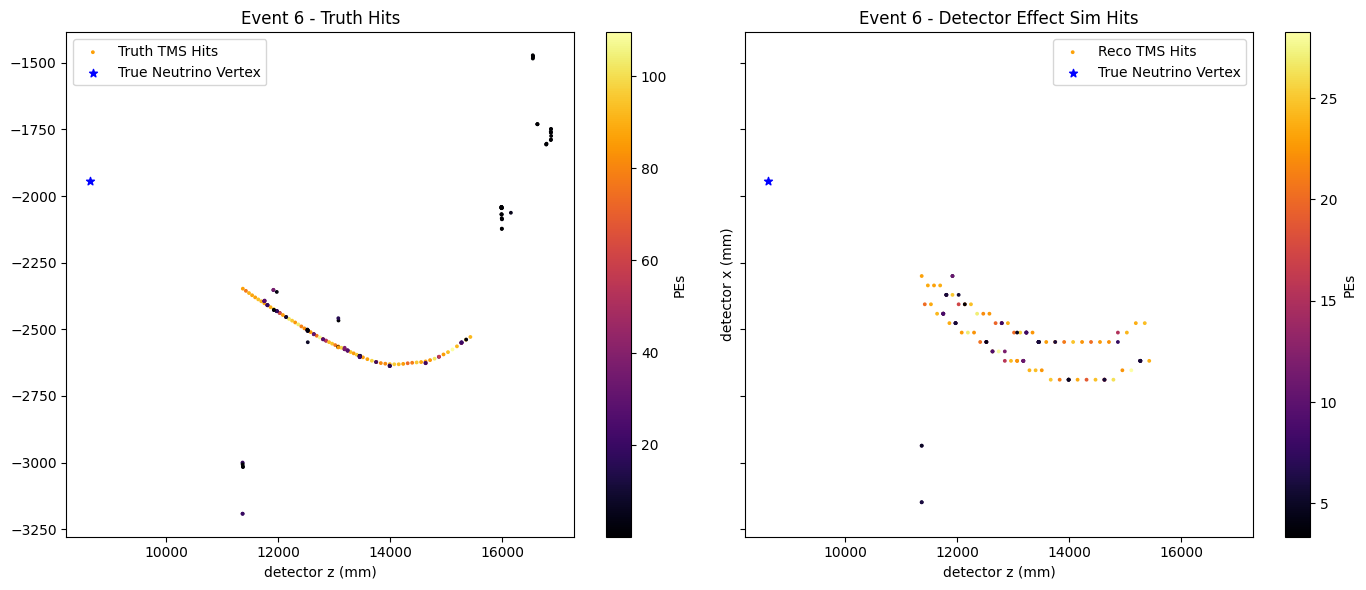

In [55]:
event_number_example = 6

# Reco hit data
reco_hit_xs = []
reco_hit_zs = []
reco_hit_PEs = []
reco_hit_Ts = []
true_hit_Ts = []

for hit in reco_hits_info:
    if hit['neutrino_num'] == event_number_example and not hit['pedestal_subtracted?']:
        reco_hit_xs.append(hit['hit_reco_position'][0])
        reco_hit_zs.append(hit['hit_reco_position'][2])
        true_hit_Ts.append(hit['hit_true_T'])
        reco_hit_Ts.append(hit['hit_reco_T'])
        reco_hit_PEs.append(hit['hit_reco_PE'][0])

# Truth hit data
truth_hit_xs = []
truth_hit_zs = []
truth_hit_PEs = []

for hit in truth_hits_info:
    if hit['neutrino_num'] == event_number_example:
        truth_hit_xs.append(hit['x'])
        truth_hit_zs.append(hit['z'])
        truth_hit_PEs.append(hit['primary_energy'] * 50.0)

# Get neutrino vertex
event_neutrino = [vtx for vtx in edep_true_neutrino_vtx if vtx["neutrino_num"] == event_number_example]

# Setup side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot reco hits
sc2 = ax2.scatter(reco_hit_zs, reco_hit_xs, s=3, c=reco_hit_PEs, cmap='inferno', label='Reco TMS Hits')
ax2.scatter(event_neutrino[0]['z'], event_neutrino[0]['x'], s=35, c='blue', marker='*', label='True Neutrino Vertex')
ax2.set_xlabel("detector z (mm)")
ax2.set_ylabel("detector x (mm)")
ax2.set_title(f"Event {event_number_example} - Detector Effect Sim Hits")
ax2.legend()
fig.colorbar(sc2, ax=ax2, label='PEs')

# Plot truth hits
sc1 = ax1.scatter(truth_hit_zs, truth_hit_xs, s=3, c=truth_hit_PEs, cmap='inferno', label='Truth TMS Hits')
ax1.scatter(event_neutrino[0]['z'], event_neutrino[0]['x'], s=35, c='blue', marker='*', label='True Neutrino Vertex')
ax1.set_xlabel("detector z (mm)")
ax1.set_title(f"Event {event_number_example} - Truth Hits")
ax1.legend()
fig.colorbar(sc1, ax=ax1, label='PEs')

plt.tight_layout()
plt.show()

We can also do a similar thing with event-wise timing plots 

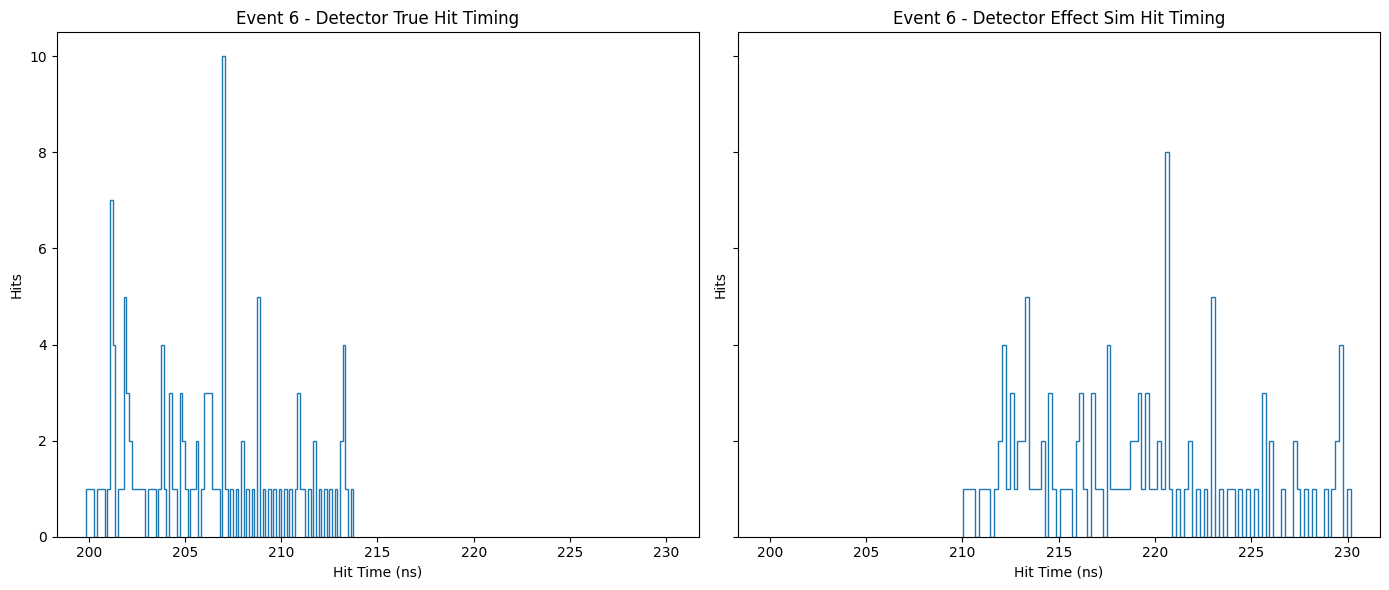

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

hist2 = ax2.hist(reco_hit_Ts, bins=100, histtype = 'step')
ax2.set_xlabel("Hit Time (ns)")
ax2.set_ylabel("Hits")
ax2.set_title(f"Event {event_number_example} - Detector Effect Sim Hit Timing")

hist1 = ax1.hist(true_hit_Ts, bins=100, histtype = 'step')
ax1.set_xlabel("Hit Time (ns)")
ax1.set_ylabel("Hits")
ax1.set_title(f"Event {event_number_example} - Detector True Hit Timing")

#Including true hits completely blows out scale since there are a ton of contributions from pedestal subtracted hits. 
plt.tight_layout()
plt.show()

In [51]:
array_events = ToArray(reco_hits_info)

In [79]:
np.shape(array_events)

(252256, 7)

In [78]:
print(array_events[0])

[ 0.00000000e+00  0.00000000e+00 -1.12036594e+03 -9.99990000e+07
  1.15880000e+04  5.08872347e+01  2.03902239e+01]


In [80]:
np.savez('hitwise_detector_sim_0002459.npz', first = neutrino_vertex_array, second = array_events)